In [1]:
#Install libraries
!pip -q install -U transformers datasets evaluate accelerate scikit-learn gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 12.8 MB/s eta 0:00:00


In [2]:

import os, json, platform, sys, math, random, shutil
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
device = 0 if torch.cuda.is_available() else -1
device


Python: 3.12.11
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
Torch: 2.8.0+cu126 | CUDA available: True


0

In [4]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/datasets/custom_sentiment_dataset.csv"
TEXT_COL  = "text"
LABEL_COL = "label"


MODEL_NAME = 'distilbert-base-uncased'

EXPORT_DIR = '/content/drive/MyDrive/sentiment_model_export'
os.makedirs(EXPORT_DIR, exist_ok=True)


Mounted at /content/drive


In [5]:
df = pd.read_csv(DATA_PATH)
assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"CSV must contain '{TEXT_COL}' and '{LABEL_COL}' columns."

df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
df = df[df[TEXT_COL].astype(str).str.strip().astype(bool)].reset_index(drop=True)
df[TEXT_COL] = df[TEXT_COL].astype(str)

print("Rows:", len(df))
df.head(3)


Rows: 500


,text,label
0,"Really bad quality, very disappointed.",negative
1,"Brilliant service, will use again.",positive
2,The movie was boring and dull.,negative


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_id'] = le.fit_transform(df[LABEL_COL].astype(str))

label2id = {label: int(i) for i, label in enumerate(le.classes_)}
id2label = {int(v): k for k, v in label2id.items()}

print("Labels:", le.classes_.tolist())
print("Mapping:", label2id)

with open('label_mapping.json', 'w') as f:
    json.dump({'label2id': label2id, 'id2label': id2label}, f, indent=2)

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label_id'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label_id'], random_state=42
)

len(train_df), len(val_df), len(test_df)


Labels: ['negative', 'neutral', 'positive']
Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


(400, 50, 50)

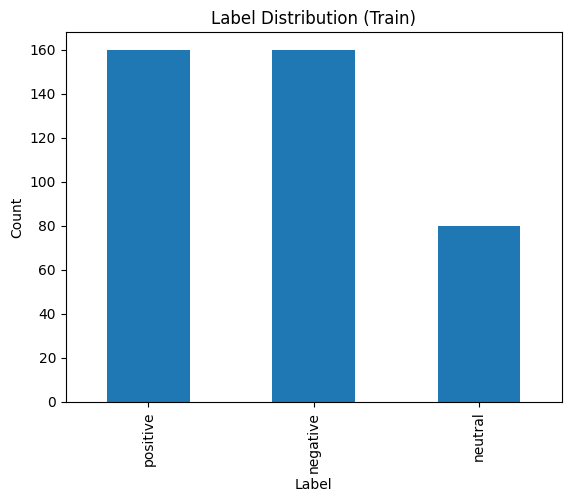

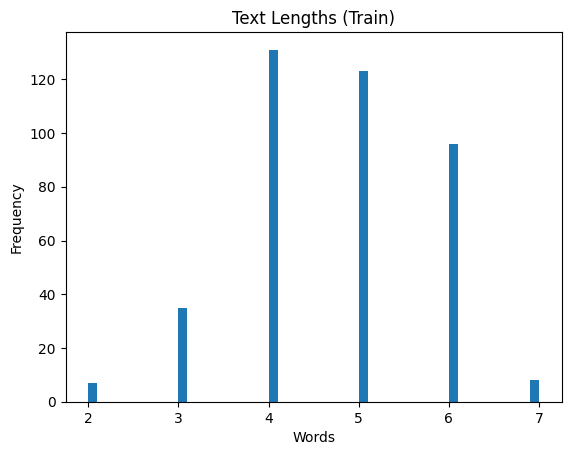

In [7]:
counts = train_df[LABEL_COL].value_counts()
ax = counts.plot(kind='bar')
ax.set_title('Label Distribution (Train)')
ax.set_xlabel('Label'); ax.set_ylabel('Count')
plt.show()

lengths = train_df[TEXT_COL].str.split().apply(len)
plt.hist(lengths, bins=50)
plt.title('Text Lengths (Train)')
plt.xlabel('Words'); plt.ylabel('Frequency')
plt.show()


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib

baseline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])

baseline.fit(train_df[TEXT_COL], train_df['label_id'])
val_pred = baseline.predict(val_df[TEXT_COL])

print("Baseline — Val Accuracy:", round(accuracy_score(val_df['label_id'], val_pred), 4))
print("Baseline — Val F1 (macro):", round(f1_score(val_df['label_id'], val_pred, average='macro'), 4))
print(classification_report(val_df['label_id'], val_pred, target_names=[id2label[i] for i in sorted(id2label)]))

joblib.dump(baseline, 'baseline_tfidf_logreg.joblib')


Baseline — Val Accuracy: 1.0
Baseline — Val F1 (macro): 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        20
     neutral       1.00      1.00      1.00        10
    positive       1.00      1.00      1.00        20

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



['baseline_tfidf_logreg.joblib']

In [9]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch[TEXT_COL], truncation=True)

ds = DatasetDict({
    'train': Dataset.from_pandas(train_df[[TEXT_COL, 'label_id']].rename(columns={'label_id':'labels'})),
    'validation': Dataset.from_pandas(val_df[[TEXT_COL, 'label_id']].rename(columns={'label_id':'labels'})),
    'test': Dataset.from_pandas(test_df[[TEXT_COL, 'label_id']].rename(columns={'label_id':'labels'})),
})

tokenized = ds.map(tokenize, batched=True, remove_columns=[TEXT_COL])
len(tokenized['train']), len(tokenized['validation']), len(tokenized['test'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

(400, 50, 50)

In [12]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load('accuracy')
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy.compute(predictions=preds, references=labels)['accuracy'],
        'f1_macro': f1.compute(predictions=preds, references=labels, average='macro')['f1'],
        'precision_macro': precision.compute(predictions=preds, references=labels, average='macro')['precision'],
        'recall_macro': recall.compute(predictions=preds, references=labels, average='macro')['recall'],
    }

args = TrainingArguments(
    output_dir='sentiment-model',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['validation'],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

print("📏 Test set metrics:")
trainer.evaluate(tokenized['test'])

best_path = 'sentiment-model/best'
trainer.save_model(best_path)
tokenizer.save_pretrained(best_path)

shutil.copytree(best_path, os.path.join(EXPORT_DIR, 'best'), dirs_exist_ok=True)
shutil.copy('label_mapping.json', os.path.join(EXPORT_DIR, 'label_mapping.json'))
print("Exported to:", EXPORT_DIR)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.622236,0.900000,0.849760,0.926219,0.833333
2,0.671500,0.244558,1.000000,1.000000,1.000000,1.000000
3,0.671500,0.159487,1.000000,1.000000,1.000000,1.000000


📏 Test set metrics:


✅ Exported to: /content/drive/MyDrive/sentiment_model_export


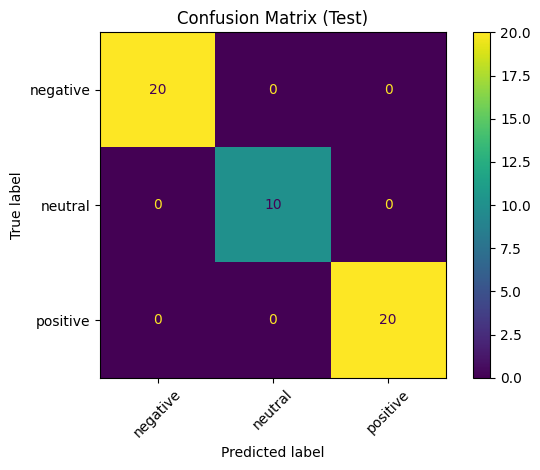

In [13]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_logits = trainer.predict(tokenized['test']).predictions
test_preds = np.argmax(test_logits, axis=-1)

cm = confusion_matrix(test_df['label_id'], test_preds, labels=list(range(num_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(num_labels)])
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()


In [14]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model=trainer.model, tokenizer=tokenizer,
    return_all_scores=True, device=device
)

def predict_text(text: str):
    out = pipe(text)[0]
    out_sorted = sorted(out, key=lambda x: x['score'], reverse=True)
    return {d['label']: float(d['score']) for d in out_sorted}

samples = [
    "I absolutely love this product. It works like a charm!",
    "Terrible experience. Would not recommend it to anyone.",
]
for s in samples:
    print(s, "->", predict_text(s))


Device set to use cuda:0


I absolutely love this product. It works like a charm! -> {'positive': 0.8562080264091492, 'negative': 0.08932303637266159, 'neutral': 0.05446893721818924}
Terrible experience. Would not recommend it to anyone. -> {'negative': 0.7393847107887268, 'neutral': 0.16234199702739716, 'positive': 0.09827326238155365}


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [15]:
import gradio as gr

def gradio_predict(text):
    return predict_text(text)

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=4, label="Enter text"),
    outputs=gr.Label(num_top_classes=len(label2id)),
    title="Sentiment Analysis",
    description="Scores per label (higher = more confident)"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f2d037a3bacc4da3d2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



## 🛠️ Troubleshooting & Tips

- **Runtime**: Use **GPU** in Colab (`Runtime → Change runtime type → GPU`) to speed up training.
- **Batch size OOM**: If you get out-of-memory errors, lower `per_device_train_batch_size` to 8 or 4.
- **Imbalanced data**: Consider class weights or data augmentation; baseline already uses `class_weight='balanced'`.
- **Different column names**: Update `TEXT_COL` and `LABEL_COL` at the top accordingly.
- **Non-CSV formats**: Convert to CSV first; ensure text and label columns are present.
- **Languages**: Swap `MODEL_NAME` to a multilingual model like `distilbert-base-multilingual-cased` if needed.
- **Saving**: Check your Drive at the path in `EXPORT_DIR` for the exported model and label mapping.
- **Accuracy**: No model is 100% accurate on real-world data. Use the metrics + confusion matrix to see where it fails and iterate.
